In [23]:
%pylab inline
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


C:\Users\Serge\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [24]:
wage = pd.read_csv('WAG_C_M.csv', sep = ';', index_col=['month'], parse_dates=['month'], dayfirst=True)

## 1. Визуальный анализ ряда:

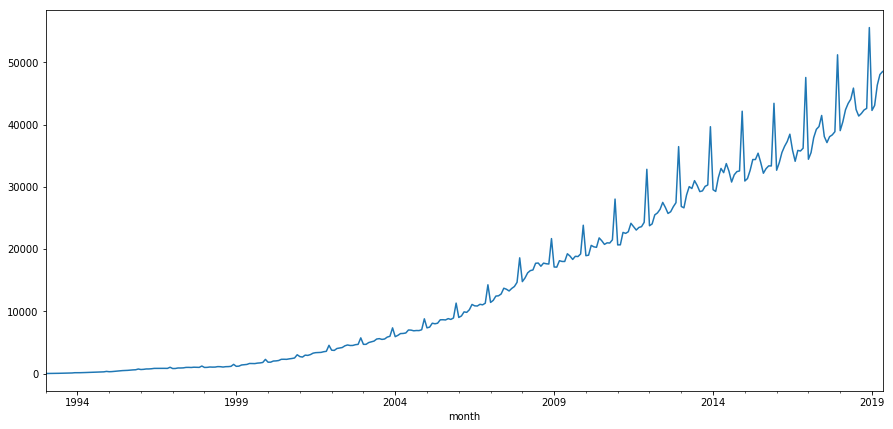

In [25]:
plt.figure(figsize(15,7))
wage.WAG_C_M.plot()

На графике явно присутствует тренд и изменяющаяся со вреенем дисперсия. Следовательно, ряд не стационарный.
Для формальной проверки используем тест Дики-Фуллера:

Критерий Дики-Фуллера: p=0.998868


<Figure size 1080x720 with 0 Axes>

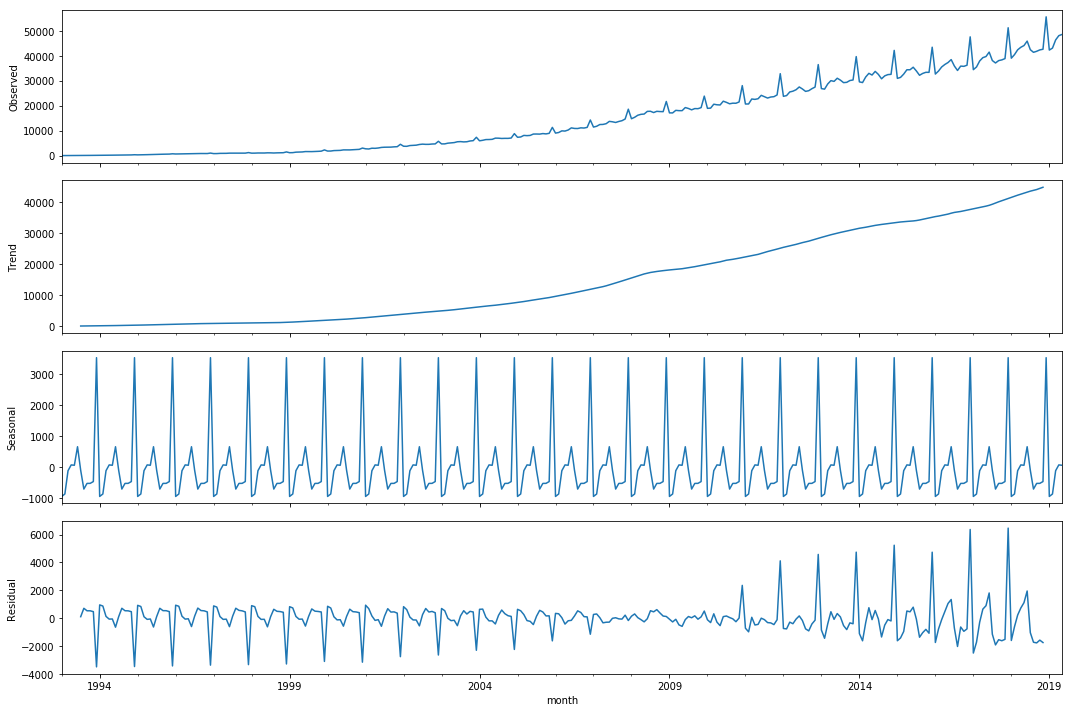

In [26]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.WAG_C_M)[1])

Достигаемый уровень значимости очень высокий, значит нулевая гипотеза не отвергается => ряд нестационарный по критерию Дики-Фуллера.

## 2. Стабилизация дисперсии:

Для стабилизации дисперсии применим преобразование Бокса-Кокса:

Оптимальный параметр преобразования Бокса-Кокса: 0.285073
Критерий Дики-Фуллера: p=0.759218


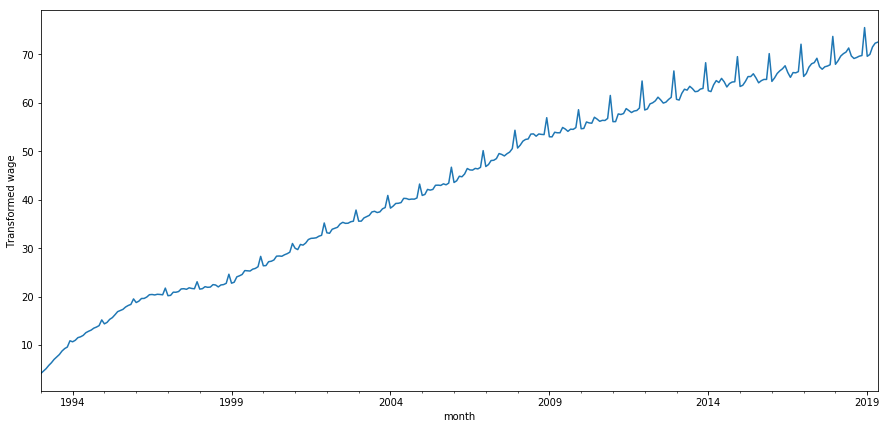

In [27]:
wage['wage_box'], lmbda = stats.boxcox(wage.WAG_C_M)
plt.figure(figsize(15,7))
wage.wage_box.plot()
plt.ylabel(u'Transformed wage')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.wage_box)[1])

После преобразования Бокса-Кокса ряд все еще не стационарен, что видно по графику и по достигаемому уровню значимости теста Дики-Фуллера.
Применим сезонное дифференциорвание.

## 3. Выбор порядка дифференцирования:

Критерий Дики-Фуллера: p=0.119001


<Figure size 1080x720 with 0 Axes>

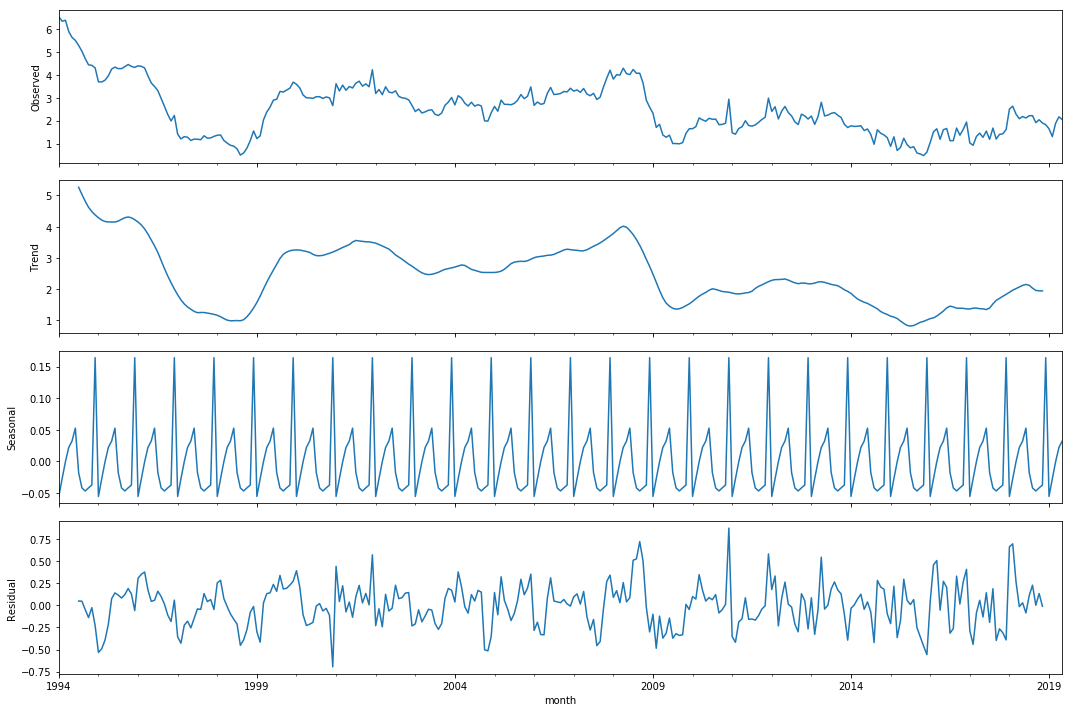

In [28]:
wage['wage_box_diff'] = wage.wage_box - wage.wage_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.wage_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.wage_box_diff[12:])[1])

После сезонного дифференцирования остается тренд и все еще высокий достигаемый уровень значимости по критерию Дики-Фуллера.
Применим обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

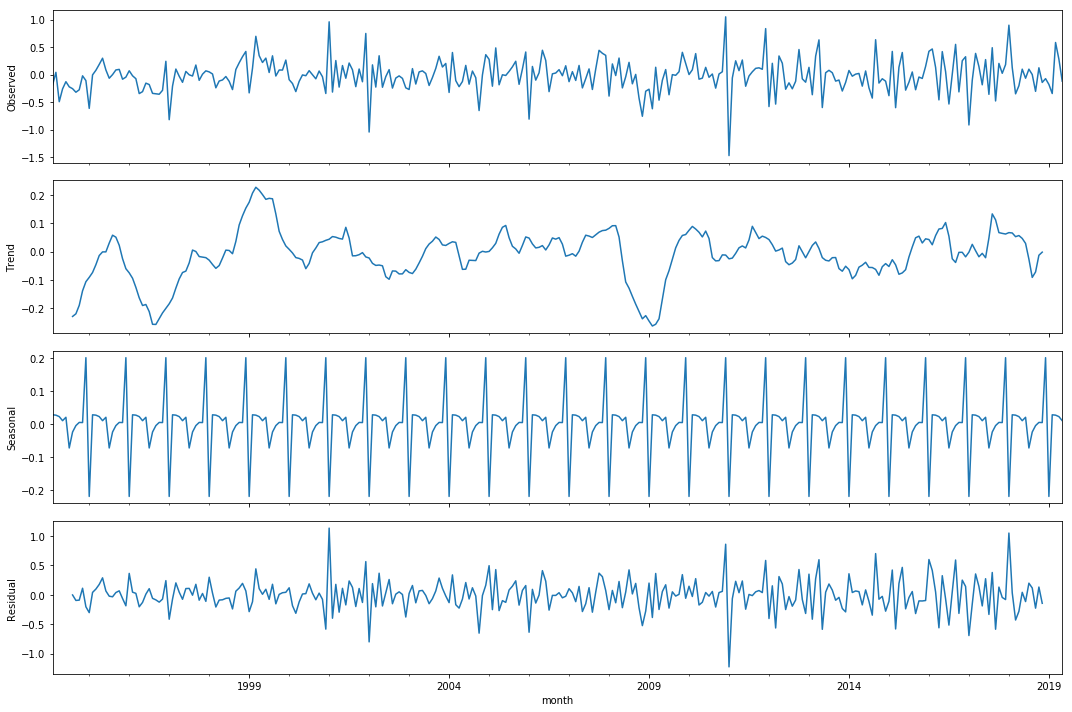

In [29]:
wage['wage_box_diff2'] = wage.wage_box_diff - wage.wage_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.wage_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.wage_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, тренд отсутствует.

## 4. Выбор начальных приближений для p,q,P,Q:

Для выбора параметров начальных приближений построим график автокорреляции и частичной автокорреляции

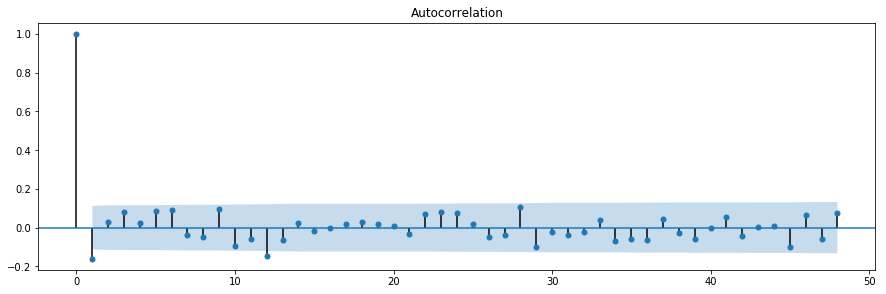

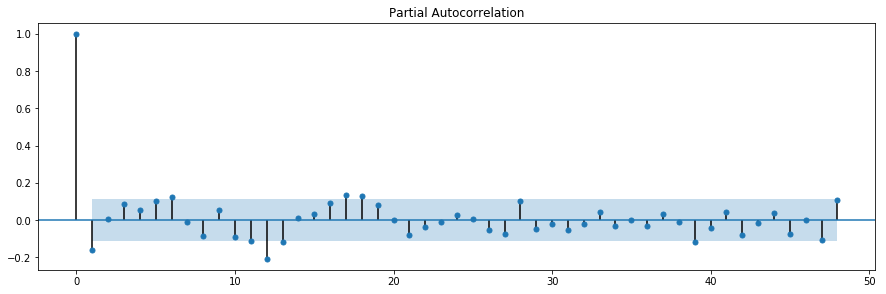

In [30]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wage.wage_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wage.wage_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Исходя из графиков начальные приближения получились:Q=1, q=1, P=1, p=1.
Для получения оптимальных параметров модели проверим следующие интервалы, содержащие начальные приближения:

In [31]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [32]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

## 5. Обучение и сравнение моделей-кандидатов, выбор победителя:

Для каждой комбинации параметров модели расчитаем критерий Акаике:

In [33]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(wage.wage_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

In [34]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
11  (1, 0, 1, 1)  124.059726
7   (0, 1, 1, 1)  124.479120
10  (1, 0, 1, 0)  125.491141
15  (1, 1, 1, 1)  125.969880
6   (0, 1, 1, 0)  125.990267


Лучшая модель:

In [35]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           wage_box   No. Observations:                  317
Model:             SARIMAX(1, 1, 0)x(1, 1, 1, 12)   Log Likelihood                 -58.030
Date:                            Sun, 29 Sep 2019   AIC                            124.060
Time:                                    19:49:06   BIC                            138.928
Sample:                                01-01-1993   HQIC                           130.007
                                     - 05-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1988      0.045     -4.462      0.000      -0.286      -0.111
ar.S.L12      -0.7330      0.133   

## 6. Анализ остатков:

Критерий Стьюдента: p=0.251436
Критерий Дики-Фуллера: p=0.000020


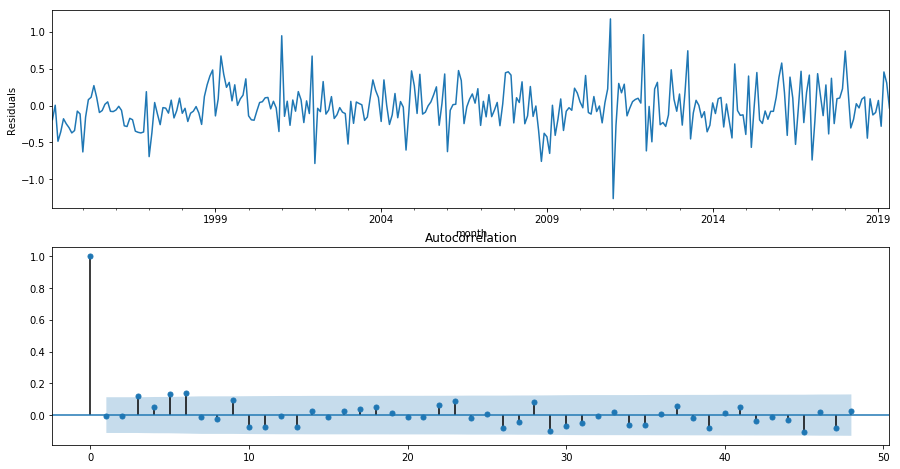

In [36]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Исходя из графика остатков можно сделать вывод об их случайности.

In [37]:
#Функция обратного преобразования Бокса-Кокса:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

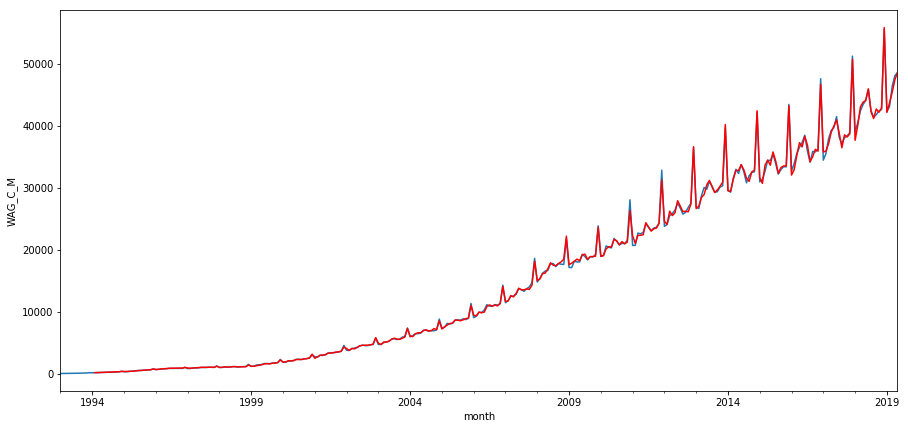

In [38]:
wage['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
wage.WAG_C_M.plot()
wage.model[13:].plot(color='r')
plt.ylabel('WAG_C_M')
pylab.show()

Исходя из сравнения графиков исходных данных и построенной модели можно сделать вывод о том, что полученная модель хорошо прогнозирует поведение ряда данных. 

## 7. Прогнозирование с помощью финальной модели:

C:\Users\Serge\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


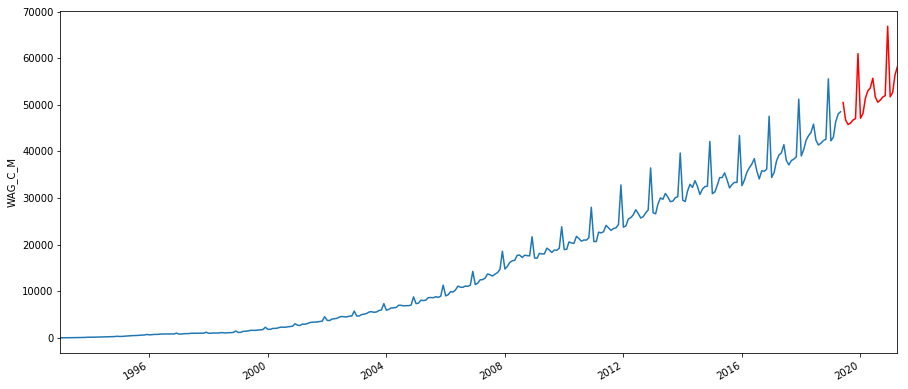

In [39]:
wage2 = wage[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2019-05-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= wage2.columns)
wage2 = pd.concat([wage2, future])
wage2['forecast'] = invboxcox(best_model.predict(start=317, end=342), lmbda)

plt.figure(figsize(15,7))
wage2.WAG_C_M.plot()
wage2.forecast.plot(color='r')
plt.ylabel('WAG_C_M')
pylab.show()